# Visualize Heatmaps of Class Activation
It is useful for understanding which parts of a given image led a convnet to its final classification decision. This is helpful for debugging the decision process of a convnet, particularly in the case of a classification mistake. It also allows us to locate specific objects in an image.

This general category of techniques is called **class activation map (CAM)** visualization, and it consists of producing heatmaps of class activation over input images. A class activation heatmap is a 2D grid of scores associated with a specific output class, computed for every location in any input image, indicating how important each location is with respect to the class under consideration. For instance, given an image fed into a dogs versus cats convnet, CAM visualization allows us to generate a heatmap for the class “cat,” indicating how cat-like different parts of the image are, and also a heatmap for the
class “dog,” indicating how dog-like parts of the image are.

The specific implementation we’ll use is the one described in *“Grad-CAM: Visual Explanations from Deep Networks via Gradient-based Localization”*. It consists of taking the output feature map of a convolution layer, given an input image, and weighing every channel in that feature map by the gradient of the class with respect to the channel. Intuitively, one way to understand this trick is that we’re weighting a spatial map of “how intensely the input image activates different channels” by “how important each channel is with regard to the class,” resulting in a spatial map of “how intensely the input image activates the class.”

We’ll demonstrate this technique using the pretrained VGG16 network again.

### Load The VGG16 Network With Pretrained Weights

In [1]:
from keras.applications.vgg16 import VGG16

model= VGG16(weights='imagenet')

Using TensorFlow backend.


Consider the image of two African elephants, possibly a mother and her calf, strolling on the savanna. Let’s convert this image into something the ```VGG16``` model can read: the model was trained on images of size *224 × 244*, preprocessed according to a few rules that are packaged in the utility function ```keras.applications.vgg16.preprocess_input```. So we need to load the image, resize it to *224 × 224*, convert it to a Numpy float32 tensor, and apply these preprocessing rules.
![elephant](https://user-images.githubusercontent.com/13174586/50001767-e629ba00-ffc3-11e8-9233-7490bd8018f0.JPG)

### Preprocess an Input Image for VGG16

In [2]:
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input, decode_predictions
import numpy

img_path='elephant.jpg' #Local path to the target image

img= image.load_img(img_path, target_size=(224,224)) #Python Imaging Library (PIL) image of size 224 × 224

x= image.img_to_array(img) #float32 Numpy array of shape (224, 224, 3)

x= x.reshape((1,)+x.shape) #Adds a dimension to transform the array into a batch of size (1, 224, 224, 3)

x= preprocess_input(x) #Preprocesses the batch (this does channel-wise color normalization)

print(x)

[[[[151.061     138.22101   119.32     ]
   [120.061      96.221      75.32     ]
   [123.061      96.221      71.32     ]
   ...
   [116.061      86.221      66.32     ]
   [112.061      80.221      65.32     ]
   [151.061     137.22101   123.32     ]]

  [[151.061     138.22101   119.32     ]
   [120.061      96.221      75.32     ]
   [123.061      96.221      71.32     ]
   ...
   [116.061      86.221      66.32     ]
   [112.061      80.221      65.32     ]
   [151.061     137.22101   123.32     ]]

  [[151.061     138.22101   119.32     ]
   [120.061      96.221      75.32     ]
   [123.061      96.221      71.32     ]
   ...
   [116.061      86.221      66.32     ]
   [112.061      80.221      65.32     ]
   [151.061     137.22101   123.32     ]]

  ...

  [[128.061     138.22101   130.32     ]
   [-27.939003   -1.7789993 -16.68     ]
   [ -9.939003   30.221      13.32     ]
   ...
   [-37.939003  -14.778999  -33.68     ]
   [-52.939003  -32.779     -36.68     ]
   [135.061     

We can now run the pretrained network on the image and decode its prediction vector back to a human-readable format:

In [3]:
preds= model.predict(x)

In [4]:
print('Predicted:', decode_predictions(preds, top=3)[0])

Predicted: [('n02504458', 'African_elephant', 0.7998774), ('n01871265', 'tusker', 0.16719908), ('n02504013', 'Indian_elephant', 0.032051224)]


The top three classes predicted for this image are as follows:
 - ***African elephant*** (with 79.9% probability)
 - ***Tusker*** (with 16.7% probability)
 - ***Indian elephant*** (with 3.2% probability)

The network has recognized the image as containing an undetermined quantity of African elephants. The entry in the prediction vector that was maximally activated is the one corresponding to the “African elephant” class, at index 386

In [5]:
import numpy as np
np.argmax(preds[0])

386

To visualize which parts of the image are the most African elephant–like, let’s set up the Grad-CAM process.

### Sett Up The Grad-CAM Algorithm

In [6]:
african_elephant_output= model.output[:,386] #“African elephant” entry in the prediction vector

last_conv_layer=model.get_layer('block5_conv3') #Output feature map of the block5_conv3 layer, the last convolutional layer in VGG16

In [7]:
from keras import backend as K

grads= K.gradients(african_elephant_output, last_conv_layer.output)[0] #Gradient of the “African elephant” class with regard to
                                                                        #the output feature map of block5_conv3
    
pooled_grads= K.mean(grads, axis=(0,1,2)) #Vector of shape (512,), where each entry is the mean intensity of the gradient
                                        #over a specific feature-map channel
    
iterate= K.function([model.input], [pooled_grads, last_conv_layer.output[0]]) #Lets us access the values of the quantities
                                                                            #we just defined: pooled_grads and the
                                                                            #output feature map of block5_conv3, given #
                                                                            #a sample image
            
pooled_grads_value, conv_layer_output_value= iterate([x]) #Values of these two quantities, as Numpy arrays, 
                                                        #given the sample image of two elephants
    
    
for i in range(512):
    conv_layer_output_value[:,:,i] *= pooled_grads_value[i]
    
heatmap= np.mean(conv_layer_output_value, axis=-1)

For visualization purposes, you’ll also normalize the heatmap between 0 and 1.
### Heatmap post-processing

In [8]:
import matplotlib.pyplot as plt

heatmap= np.maximum(heatmap,0)
heatmap/=np.max(heatmap)

plt.matshow(heatmap)
plt.show()

<Figure size 480x480 with 1 Axes>

Finally, we’ll use OpenCV to generate an image that superimposes the original image on the heatmap we just obtained

### Superimpose The Heatmap With The Original Picture

In [9]:
import cv2
img= cv2.imread(img_path) #Uses cv2 to load the original image

heatmap= cv2.resize(heatmap, (img.shape[1], img.shape[0])) #Resizes the heatmap to be the same size as the original image

heatmap= np.uint8(255*heatmap) #Converts the heatmap to RGB

heatmap= cv2.applyColorMap(heatmap, cv2.COLORMAP_JET) #Applies the heatmap to the original image
superimposed_img= heatmap*0.4 +img

cv2.imwrite('elephant_CAM.jpg', superimposed_img) #Saves the image to disk

True

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


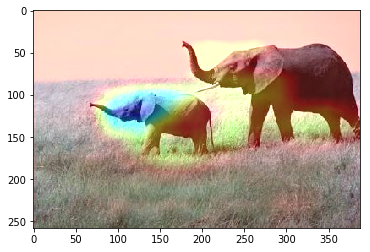

In [18]:
plt.imshow(superimposed_img/255)
plt.show()

Saved elephant CAM Image
![elephant_cam](https://user-images.githubusercontent.com/13174586/50004809-54737a00-ffce-11e8-9640-3492e634b9d8.jpg)


This visualization technique answers two important questions:
 - Why did the network think this image contained an African elephant?
 - Where is the African elephant located in the picture?
 
In particular, it’s interesting to note that the ears of the elephant calf are strongly activated: this is probably how the network can tell the difference between African and Indian elephants.